In [12]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import trame

In [32]:
# Enable notebook rendering
pv.set_jupyter_backend('static')

### 1. Create Circles / Splines and Extrude Them to Form Cylinders / Curved Planes

In [30]:
# # Create a spline curve in the x-z plane
# def create_spline_curve(points, n_points=100):
#     spline = pv.Spline(points, n_points=n_points)
#     t_values = np.linspace(0, 1, n_points)
#     return spline, t_values

# # Generate example points for the spline curve
# points = np.array([[-10, 0, 0], [-5, 0, 5], [0, 0, 10], [5, 0, 5], [10, 0, 0]])
# spline_curve, t_values = create_spline_curve(points)

# # Extrude the spline curve in the y direction to create curved planes
# def extrude_spline_curve(spline_curve, extrusion_length):
#     extruded = spline_curve.extrude([0, extrusion_length, 0])
#     return extruded

# extrusion_length = 10  # Length to extrude in the y direction
# curved_plane_outer = extrude_spline_curve(spline_curve, extrusion_length)

# # Create a spline curve for the inner part by slightly scaling down the points
# inner_points = points * 0.5
# spline_curve_inner, t_values_inner = create_spline_curve(inner_points)
# curved_plane_inner = extrude_spline_curve(spline_curve_inner, extrusion_length)


In [76]:
# Create a circle in the x-z plane
def create_circle(radius, n_points=100):
    theta = np.linspace(0, 2 * np.pi, n_points)
    x = radius * np.cos(theta)
    z = radius * np.sin(theta)
    points = np.vstack((x, np.zeros(n_points), z)).T
    lines = np.column_stack((np.full(n_points, 2), np.arange(n_points), np.roll(np.arange(n_points), -1)))
    lines = lines.flatten()
    circle = pv.PolyData(points)
    circle.lines = lines
    return circle

# Extrude the circles in the y direction to create cylinders
def extrude_circle(circle, extrusion_length_pos, extrusion_length_neg):
    extruded_pos = circle.extrude([0, extrusion_length_pos, 0])
    extruded_neg = circle.extrude([0, extrusion_length_neg, 0])
    extruded = extruded_pos + extruded_neg
    return extruded



In [77]:
# Load the intraoral mesh
intraoral_mesh = pv.read(r'D:\sunny\Codes\DPS\data\Origin\000101_origin.ply')

# Calculate the radii: 
# the outer radius is the maximum distance from the origin
# the inner radius is the minimum distance
distances = np.linalg.norm(intraoral_mesh.points[:, [0, 2]], axis=1)
outer_radius = np.max(distances)
inner_radius = np.min(distances)
n_points = 100

# Calculate the extrusion length
y_min = np.min(intraoral_mesh.points[:, 1])
y_max = np.max(intraoral_mesh.points[:, 1])
extrusion_length_pos = y_max
extrusion_length_neg = y_min
print(f'Extrusion length: {extrusion_length_pos} (pos), {extrusion_length_neg} (neg)')

# Create the circles
circle_outer = create_circle(outer_radius, n_points)
circle_inner = create_circle(inner_radius, n_points)
# Extrude the circles to create cylinders
cylinder_outer = extrude_circle(circle_outer, extrusion_length_pos, extrusion_length_neg)
cylinder_inner = extrude_circle(circle_inner, extrusion_length_pos, extrusion_length_neg)


Extrusion length: -0.1180529072880745 (pos), -21.39175796508789 (neg)


d:\Users\sunny\anaconda3\envs\env_dps\lib\site-packages\pyvista\core\filters\poly_data.py:2997: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


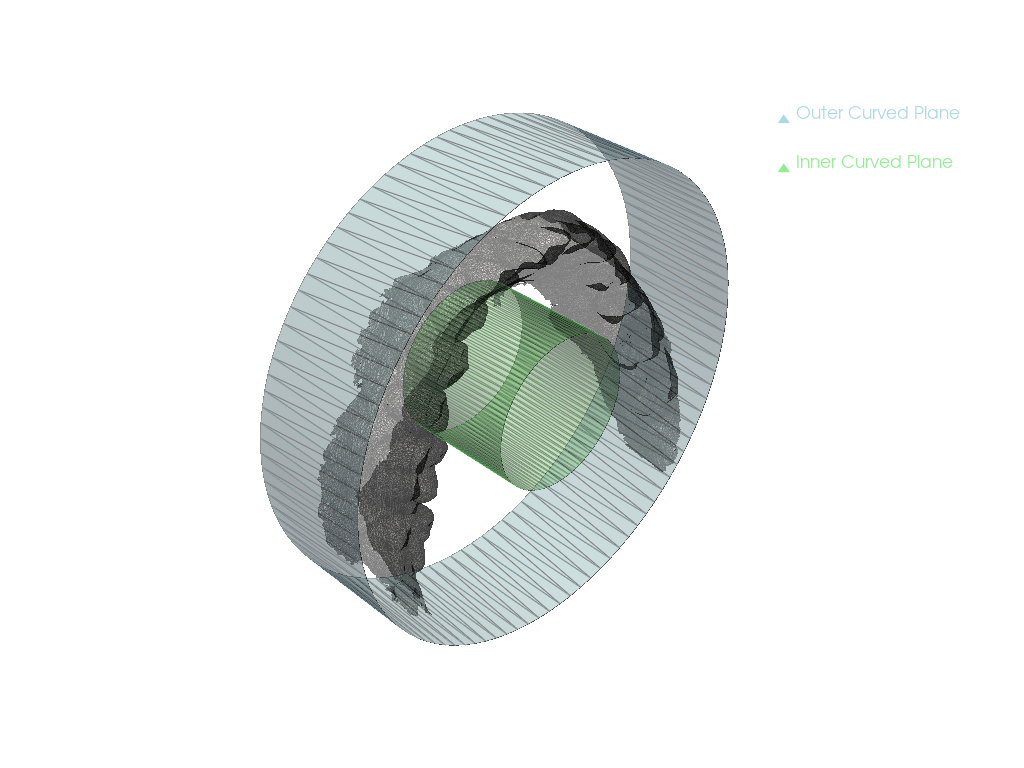

In [78]:
# Visualize the curved planes overlaid with the original mesh
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(intraoral_mesh, color='white', opacity=0.5, show_edges=True, label='Original Mesh')
plotter.add_mesh(cylinder_outer, color='lightblue', opacity=0.5, show_edges=True, label='Outer Curved Plane')
plotter.add_mesh(cylinder_inner, color='lightgreen', opacity=0.5, show_edges=True, label='Inner Curved Plane')
plotter.add_legend()
plotter.show()

### 2. Define the Projection Function with Color Information

In [79]:
# Function to project a mesh onto a cylinder and embed color information
def project_mesh_onto_cylinder(mesh, radius, y_min, y_max, is_inner=False):
    projected_uv = []
    colors = []
    extrusion_length = y_max - y_min
    for point, color in zip(mesh.points, mesh.point_data['RGB']):
        x, y, z = point
        theta = np.arctan2(z, x)
        r = np.sqrt(x**2 + z**2)
        if is_inner:
            if r>=radius: # For inner cylinder, we project if the point is outside the radius
                uv = [theta / (2 * np.pi), (y - y_min) / extrusion_length]
                projected_uv.append(uv)
                colors.append(color / 255.0)
        else: # For outer cylinder, we project if the point is inside the radius
            if r <= radius:
                uv = [theta / (2 * np.pi), (y - y_min) / extrusion_length]
                projected_uv.append(uv)
                colors.append(color / 255.0)  # Normalize color to [0, 1]
    projected_uv = np.array(projected_uv)
    colors = np.array(colors)
    print(f'Projected UV: {projected_uv.shape}')
    print(f'Colors: {colors.shape}')
    return projected_uv, colors

### 3. Load the Intraoral Mesh and Apply Projections

Projected UV: (33602, 2)
Colors: (33602, 3)
Projected UV: (0,)
Colors: (0,)


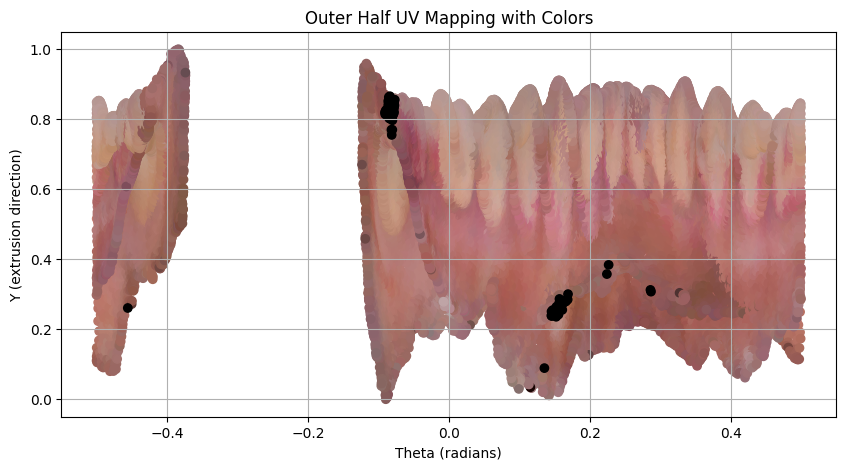

No UV coordinates to plot for Inner Half UV Mapping with Colors


In [80]:
# Visualize the projections with color information
def visualize_uv_mapping_with_colors(mesh, uv_coords, colors, title):
    if uv_coords.size == 0:
        print(f'No UV coordinates to plot for {title}')
        return
    plt.figure(figsize=(10, 5))
    plt.scatter(uv_coords[:, 0], uv_coords[:, 1], c=colors, marker='o')
    plt.title(title)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Y (extrusion direction)')
    plt.grid(True)
    plt.show()


# Project the mesh onto the cylinders
projected_outer_uv, colors_outer = project_mesh_onto_cylinder(intraoral_mesh, outer_radius, y_min, y_max)
projected_inner_uv, colors_inner = project_mesh_onto_cylinder(intraoral_mesh, inner_radius, y_min, y_max)

# Visualize the projections with color information
visualize_uv_mapping_with_colors(intraoral_mesh, projected_outer_uv, colors_outer, 'Outer Half UV Mapping with Colors')
visualize_uv_mapping_with_colors(intraoral_mesh, projected_inner_uv, colors_inner, 'Inner Half UV Mapping with Colors')